In [1]:
import optuna
from tqdm import tqdm
import logging
import sys
import torch
import os
from datetime import datetime
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#import torch.utils.data
#from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split, Dataset, DataLoader
from PIL import Image
import zookeeper as zk  # convool_size & mappy
import pickle  # for artifact, maybe not useful

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


import shutil
    
data = pd.read_csv('../data/og/training_solutions_rev1.csv')
test = data.sample(frac=.1)
train = data.drop(test.index)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train.to_csv('../data/training/training_solutions_rev1.csv', index_label=False)
test.to_csv('../data/test/test_solutions_rev1.csv', index_label=False)

for image in (train.GalaxyID.astype('string') + '.jpg').values:
    shutil.move(os.path.join('../data/og/', image), os.path.join('../data/training/', image))

for image in (test.GalaxyID.astype('string') + '.jpg').values:
    shutil.move(os.path.join('../data/og/', image), os.path.join('../data/test/', image))

train.head()


pd.read_csv('../data/test/test_solutions_rev1.csv').shape[0] + pd.read_csv('../data/training/training_solutions_rev1.csv').shape[0]

### Define Dataset function

In [4]:
class GalaxyJungle(Dataset):
    
    #the init function initializes the directory containing the image,
    #the annotations file,
    #and both transforms
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, is_rgb=False):
        self.rgb = is_rgb
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    #returns number of samples in the dataset
    def __len__(self):
        return (self.img_labels).shape[0]

    #loads a sample from the dataset
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])) + '.jpg'
        #retrieves the image
        image = Image.open(img_path)
        if not self.rgb: image = image.convert('L')
        #retrieves corresponding label
        label = self.img_labels.iloc[idx, 1:]
        #if possible, transform the image and the label into a tensor.
        if self.transform:
            image = self.transform(image)#.type(torch.float16)
        label = torch.tensor(label.values, dtype=torch.float32)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, self.img_labels.iloc[idx, 0]
    

transfs = transforms.Compose([
    transforms.ToTensor(), # Riscala le immagini tra 0 e 1
    transforms.CenterCrop(324),
    transforms.Resize(128),
    transforms.RandomRotation(180)
    ])

## NEURAL NETWORK

In [5]:
class GalaxyNet(nn.Module):
    def __init__(self, activation, initialization=False, is_rgb=False):
        super().__init__()
        
        rgb = 3 if is_rgb else 1
        input_size = 128
        num_labels = 37
        
        self.loss_dict = {'batch' : [], 'epoch' : [], 'vbatch' : [], 'vepoch' : []}
        self.activation = activation

        
        ## convolutional layers
        self.convs = nn.Sequential(
            nn.Conv2d(rgb, 16, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(16),

            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 16, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(16),

            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(128),            

            nn.MaxPool2d(2)
            )

        for layer in self.convs:
            if layer.__class__.__name__ == 'Conv2d': input_size = zk.convool_size(input_size, 3, 1)
            elif layer.__class__.__name__ == 'MaxPool2d': input_size = zk.convool_size(input_size, 2, 2)

        if input_size < 2: raise ValueError('You shrank too much dude.')
        print(f'Convs output size: {input_size}')

        input_linear = 128 * input_size * input_size
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_linear, 100),
            self.activation(),
            nn.Linear(100, num_labels)
            )
        
        if initialization: self.init_weights()



    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x)
        return x



    def init_weights(self):
        if self.activation == nn.ReLU:
            nonlin = 'relu'
            a = 0
        elif self.activation == nn.LeakyReLU:
            nonlin = 'leaky_relu'
            a = .01
        
        # Init convolutional parameters
        for layer in self.convs: 
            if layer.__class__.__name__ == 'Conv2d': nn.init.kaiming_normal_(layer.weight, a=a, nonlinearity=nonlin)
        

        # Init linear parameters
        for i in (1, -1): nn.init.constant_(self.fc[i].bias, 0)
        nn.init.kaiming_normal_(self.fc[1].weight, a=a, nonlinearity=nonlin)
        nn.init.xavier_uniform_(self.fc[-1].weight)      
        


    def log_the_loss(self, item,epoch=False): # per avere una history della loss???
        verbose=False
        train = self.__getstate__()['training']
        if verbose: print(train)
        if epoch and train:
            self.loss_dict['epoch'].append(item) ### get state of the model so you can ditch the validation parameter
        elif not epoch and train:
            self.loss_dict['batch'].append(item)
        elif not train and epoch:
            self.loss_dict['vepoch'].append(item)
        elif not train and not epoch:
            self.loss_dict['vbatch'].append(item)
        return item

## TRAINING + VALIDATION

In [40]:
def one_epoch_train(model, train_loader, optimizer, loss_function, verbose=False):
    running_loss = 0
    model.train()
    for i, data in tqdm(enumerate(train_loader)):
        inputs,labels, _ = data
        inputs,labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss=loss_function(outputs, labels)
        loss.backward()
        optimizer.step() # fa update del parameter
        RMSEloss = np.sqrt(loss.item())
        running_loss += RMSEloss
        if verbose and i%10 ==0: print(f'Batch {i+1}/{len(train_loader)} - Loss: {RMSEloss:.3f}')

        model.log_the_loss(RMSEloss, epoch=False)
    epochmean_loss = running_loss / len(train_loader)
    print(f'\nLoss: {epochmean_loss}')
    model.log_the_loss(epochmean_loss, epoch=True)
    last_loss = RMSEloss
    print(f"Last loss: {last_loss}")
    return epochmean_loss



def one_epoch_eval(model, test_loader, loss_function, verbose=False):
    model.eval()
    running_validation_loss = 0.
   
    with torch.no_grad(): # deactivates gradient evaluation
        for i, vdata in tqdm(enumerate(test_loader)):
            inputs,labels, _ = vdata
            inputs,labels= inputs.to(device), labels.to(device)
            outputs = model(inputs)#, activation=F.relu)
            loss = loss_function(outputs ,labels)
            RMSEloss = np.sqrt(loss.item())
            running_validation_loss +=RMSEloss
            model.log_the_loss(RMSEloss,epoch=False)
    mean_vloss=model.log_the_loss(running_validation_loss / len(test_loader),epoch=True)
    print(f"Validation Loss: {mean_vloss}\n---")
    return mean_vloss

## OPTUNA


In [41]:
DS = GalaxyJungle('../data/training/training_solutions_rev1.csv', '../data/training/', transfs)
training, test = random_split(DS, [.8, .2])

artifact_store = optuna.artifacts.FileSystemArtifactStore(base_path='./artifacts')

def objective(trial:optuna.Trial):
    epochs = 50
    loss_function = nn.MSELoss()
    train_loader = DataLoader(training, batch_size=32, shuffle=True, num_workers=os.cpu_count())
    test_loader = DataLoader(test, batch_size=32, shuffle=False, num_workers=os.cpu_count())    
    
    # Trial choices
    activation = trial.suggest_categorical("activation", ['ReLU', 'LeakyReLU'])
    optimizer = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'AdamW', 'RMSprop', 'Adagrad', 'NAdam']) #AdamW è suggerito per CNN.
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True) #log true cerca i valori in scala logaritmica
    momentum = trial.suggest_float("momentum", 0.5, 0.9, step=0.1) #per SGD
    initialization = trial.suggest_categorical('init weight', [True, False])
    
    # Training phase
    activation = getattr(nn, activation)
    model = GalaxyNet(activation, initialization).to(device)
    if optimizer in ('SGD', "RMSprop"): optimizer = getattr(optim, optimizer)(model.parameters(), lr=learning_rate, momentum = momentum)
    else: optimizer = getattr(optim, optimizer)(model.parameters(), lr=learning_rate)
    
    
    for epoch in range(epochs):
        print(f'Training epoch {epoch}')
        one_epoch_train(model, train_loader, optimizer, loss_function, verbose=False)

        print(f'Validation epoch {epoch}')
        epoch_last_val_loss = one_epoch_eval(model, test_loader, loss_function, verbose=False)
        trial.report(epoch_last_val_loss, epoch)


        if trial.should_prune(): raise optuna.TrialPruned()

    with open('model.pickle', 'wb') as fout: pickle.dump(model, fout)
    art_id = optuna.artifacts.upload_artifact(artifact_store=artifact_store, file_path='model.pickle', study_or_trial=trial.study)
    trial.set_user_attr('artifact_id', art_id)

    
    return epoch_last_val_loss

In [42]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "JAGZooNet"
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction='minimize', study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(objective, n_trials=1)

[I 2025-05-22 16:14:11,745] A new study created in RDB with name: JAGZooNet


A new study created in RDB with name: JAGZooNet
A new study created in RDB with name: JAGZooNet
A new study created in RDB with name: JAGZooNet
A new study created in RDB with name: JAGZooNet
A new study created in RDB with name: JAGZooNet
Convs output size: 2
Training epoch 0


1386it [00:54, 25.35it/s]


Loss: 0.29175342888752726
Last loss: 0.19072424775146632
Validation epoch 0



347it [00:13, 24.82it/s]

Validation Loss: 0.1833262158622338
---
Training epoch 1



1386it [00:53, 25.83it/s]


Loss: 0.16886460035312867
Last loss: 0.15607346456376758
Validation epoch 1



347it [00:13, 24.81it/s]

Validation Loss: 0.1644279374721887
---
Training epoch 2



1386it [00:51, 26.96it/s]


Loss: 0.16268904557464592
Last loss: 0.15585490581252362
Validation epoch 2



347it [00:12, 28.73it/s]

Validation Loss: 0.16139866507807085
---
Training epoch 3



1386it [00:50, 27.56it/s]


Loss: 0.15888403400445372
Last loss: 0.15773990892524759
Validation epoch 3



347it [00:14, 24.33it/s]

Validation Loss: 0.15616983044172777
---
Training epoch 4



1386it [00:54, 25.63it/s]


Loss: 0.15050927165194972
Last loss: 0.1530766038417045
Validation epoch 4



347it [00:14, 24.36it/s]

Validation Loss: 0.14365694941012047
---
Training epoch 5



1386it [00:56, 24.41it/s]


Loss: 0.13848894717167268
Last loss: 0.15272462745450283
Validation epoch 5



347it [00:12, 28.83it/s]

Validation Loss: 0.13465304486330018
---
Training epoch 6



1386it [00:49, 27.78it/s]


Loss: 0.1326099990409554
Last loss: 0.12601624832188357
Validation epoch 6



347it [00:14, 24.52it/s]

Validation Loss: 0.13240186585343408
---
Training epoch 7



1386it [00:50, 27.32it/s]


Loss: 0.1291576139120692
Last loss: 0.11030673914339499
Validation epoch 7



347it [00:11, 29.08it/s]


Validation Loss: 0.12678670720245533
---
Training epoch 8


1386it [00:50, 27.70it/s]


Loss: 0.1261935109052163
Last loss: 0.1333524024137292
Validation epoch 8



347it [00:11, 29.10it/s]


Validation Loss: 0.12388610388035806
---
Training epoch 9


1386it [00:49, 27.84it/s]


Loss: 0.12354637748307964
Last loss: 0.11687889392888799
Validation epoch 9



347it [00:12, 28.63it/s]


Validation Loss: 0.12228022774487472
---
Training epoch 10


1386it [00:49, 28.17it/s]


Loss: 0.12127079467847271
Last loss: 0.1452261932493943
Validation epoch 10



347it [00:11, 29.39it/s]

Validation Loss: 0.11949961192626904
---
Training epoch 11



1386it [00:51, 26.98it/s]


Loss: 0.11908749320948597
Last loss: 0.12020051206041912
Validation epoch 11



347it [00:11, 29.02it/s]

Validation Loss: 0.11721539262175533
---
Training epoch 12



1386it [00:48, 28.32it/s]


Loss: 0.117229389705333
Last loss: 0.11202314579619298
Validation epoch 12



347it [00:12, 28.91it/s]

Validation Loss: 0.11568141882979867
---
Training epoch 13



1386it [00:50, 27.63it/s]


Loss: 0.11566486936589085
Last loss: 0.10316764625266947
Validation epoch 13



347it [00:11, 29.06it/s]


Validation Loss: 0.11368132582207416
---
Training epoch 14


1386it [00:49, 28.19it/s]


Loss: 0.1143537281731328
Last loss: 0.10729771287634551
Validation epoch 14



347it [00:12, 28.87it/s]

Validation Loss: 0.11365234090687308
---
Training epoch 15



1386it [00:50, 27.37it/s]


Loss: 0.113203491025928
Last loss: 0.11578951887830068
Validation epoch 15



347it [00:12, 28.19it/s]


Validation Loss: 0.1121015299167292
---
Training epoch 16


1386it [00:50, 27.37it/s]


Loss: 0.11217997257531623
Last loss: 0.10273253489974943
Validation epoch 16



347it [00:11, 29.19it/s]

Validation Loss: 0.11109137126533979
---
Training epoch 17



1386it [00:49, 28.04it/s]


Loss: 0.11149816241385559
Last loss: 0.12233414177417412
Validation epoch 17



347it [00:12, 28.79it/s]


Validation Loss: 0.11070952512384617
---
Training epoch 18


1386it [00:48, 28.39it/s]


Loss: 0.11061706585572575
Last loss: 0.10027055926440365
Validation epoch 18



347it [00:11, 28.96it/s]

Validation Loss: 0.10948602101902626
---
Training epoch 19



1386it [00:47, 29.24it/s]


Loss: 0.10998347242829268
Last loss: 0.11054715402520758
Validation epoch 19



347it [00:12, 28.85it/s]

Validation Loss: 0.11014866794886628
---
Training epoch 20



1386it [00:48, 28.50it/s]


Loss: 0.10910235460001345
Last loss: 0.12060619848239074
Validation epoch 20



347it [00:12, 27.81it/s]

Validation Loss: 0.10950242355412496
---
Training epoch 21



1386it [00:52, 26.42it/s]


Loss: 0.10878219199138854
Last loss: 0.11667835176723096
Validation epoch 21



347it [00:11, 29.01it/s]


Validation Loss: 0.10768012287098068
---
Training epoch 22


1386it [00:49, 28.25it/s]


Loss: 0.10826217051639146
Last loss: 0.10323324464970432
Validation epoch 22



347it [00:11, 29.11it/s]

Validation Loss: 0.10743523765797955
---
Training epoch 23



1386it [01:01, 22.63it/s]


Loss: 0.10768549968984246
Last loss: 0.11437846196125691
Validation epoch 23



347it [00:13, 26.12it/s]

Validation Loss: 0.10722243241607378
---
Training epoch 24



1386it [00:54, 25.47it/s]


Loss: 0.10727545807435665
Last loss: 0.13317624237541958
Validation epoch 24



347it [00:11, 30.40it/s]

Validation Loss: 0.10610762738449923
---
Training epoch 25



1386it [00:50, 27.53it/s]


Loss: 0.10677591165023075
Last loss: 0.11527256413655372
Validation epoch 25



347it [00:11, 30.05it/s]

Validation Loss: 0.10608844302024
---
Training epoch 26



1386it [01:03, 21.79it/s]


Loss: 0.10628302239795892
Last loss: 0.09825451699579953
Validation epoch 26



347it [00:16, 20.97it/s]

Validation Loss: 0.10545139219674582
---
Training epoch 27



1386it [01:12, 19.11it/s]


Loss: 0.10580235013041622
Last loss: 0.10563138061499788
Validation epoch 27



347it [00:12, 28.76it/s]

Validation Loss: 0.10477823710690037
---
Training epoch 28



1386it [00:49, 28.13it/s]


Loss: 0.1054265250039724
Last loss: 0.12202995014475257
Validation epoch 28



347it [00:12, 28.72it/s]

Validation Loss: 0.10540912400064498
---
Training epoch 29



1386it [00:49, 28.22it/s]


Loss: 0.10495068025028928
Last loss: 0.11838491545094317
Validation epoch 29



347it [00:12, 28.86it/s]

Validation Loss: 0.10430842880346063
---
Training epoch 30



1386it [00:49, 28.21it/s]


Loss: 0.10495923941007385
Last loss: 0.1075550121281138
Validation epoch 30



347it [00:11, 28.98it/s]

Validation Loss: 0.10405474593890753
---
Training epoch 31



1386it [00:51, 26.86it/s]


Loss: 0.10453633016254996
Last loss: 0.12740868480854997
Validation epoch 31



347it [00:12, 28.83it/s]

Validation Loss: 0.10355791009316803
---
Training epoch 32



1386it [00:53, 26.05it/s]


Loss: 0.10433043225405457
Last loss: 0.10156613581825229
Validation epoch 32



347it [00:12, 27.23it/s]

Validation Loss: 0.10340081011976703
---
Training epoch 33



1386it [00:49, 28.19it/s]


Loss: 0.10382521921196447
Last loss: 0.10725265525929964
Validation epoch 33



347it [00:11, 29.28it/s]

Validation Loss: 0.10318489663414747
---
Training epoch 34



1386it [00:48, 28.35it/s]


Loss: 0.10361410636262297
Last loss: 0.10423526640905285
Validation epoch 34



347it [00:13, 25.09it/s]

Validation Loss: 0.10298402101919858
---
Training epoch 35



1386it [00:50, 27.56it/s]


Loss: 0.10335461417854795
Last loss: 0.08818224370436269
Validation epoch 35



347it [00:12, 28.12it/s]

Validation Loss: 0.10275863801287188
---
Training epoch 36



1386it [00:51, 27.03it/s]


Loss: 0.1031618760179823
Last loss: 0.09090119011403351
Validation epoch 36



347it [00:12, 28.77it/s]

Validation Loss: 0.10271387443348746
---
Training epoch 37



1386it [00:50, 27.71it/s]


Loss: 0.10287569511070564
Last loss: 0.10322761054587096
Validation epoch 37



347it [00:12, 28.81it/s]

Validation Loss: 0.10234320704286338
---
Training epoch 38



1386it [00:55, 25.00it/s]


Loss: 0.10254748578819539
Last loss: 0.10458586406527089
Validation epoch 38



347it [00:12, 27.75it/s]

Validation Loss: 0.10196653507891464
---
Training epoch 39



1386it [00:51, 26.77it/s]


Loss: 0.10229160306163543
Last loss: 0.11335254760362504
Validation epoch 39



347it [00:11, 29.16it/s]

Validation Loss: 0.10145966595288167
---
Training epoch 40



1386it [00:49, 27.89it/s]


Loss: 0.10212572367870462
Last loss: 0.08997026119374145
Validation epoch 40



347it [00:12, 26.99it/s]


Validation Loss: 0.10240574138708051
---
Training epoch 41


1386it [00:49, 27.97it/s]


Loss: 0.10199448051957052
Last loss: 0.09835495382860708
Validation epoch 41



347it [00:12, 28.49it/s]

Validation Loss: 0.1016901267546609
---
Training epoch 42



1386it [00:52, 26.34it/s]


Loss: 0.10169271110192668
Last loss: 0.10299450228859831
Validation epoch 42



347it [00:13, 25.44it/s]

Validation Loss: 0.10208584725546561
---
Training epoch 43



1386it [00:53, 25.76it/s]


Loss: 0.10137022919229108
Last loss: 0.11030868946496673
Validation epoch 43



347it [00:12, 28.50it/s]


Validation Loss: 0.10106327343832747
---
Training epoch 44


1386it [00:50, 27.59it/s]


Loss: 0.10123567928750887
Last loss: 0.10607295133718188
Validation epoch 44



347it [00:13, 25.09it/s]

Validation Loss: 0.10060568468847485
---
Training epoch 45



1386it [00:50, 27.48it/s]


Loss: 0.10092094191677078
Last loss: 0.07813291211594382
Validation epoch 45



347it [00:13, 25.83it/s]

Validation Loss: 0.10044623344522774
---
Training epoch 46



1386it [00:55, 25.16it/s]


Loss: 0.10091438834726554
Last loss: 0.08893378874587764
Validation epoch 46



347it [00:12, 28.73it/s]


Validation Loss: 0.10044416483145362
---
Training epoch 47


1386it [00:49, 27.93it/s]


Loss: 0.10073037277625747
Last loss: 0.12333457101891428
Validation epoch 47



347it [00:12, 28.58it/s]


Validation Loss: 0.1016591135482258
---
Training epoch 48


1386it [00:51, 26.99it/s]


Loss: 0.10044680162418017
Last loss: 0.10247871803110006
Validation epoch 48



347it [00:14, 23.61it/s]

Validation Loss: 0.1003794298814045
---
Training epoch 49



1386it [00:51, 26.89it/s]


Loss: 0.10046662956486922
Last loss: 0.1153894568947856
Validation epoch 49



347it [00:12, 28.14it/s]


Validation Loss: 0.10003006981883567
---


[I 2025-05-22 17:08:15,471] Trial 0 finished with value: 0.10003006981883567 and parameters: {'activation': 'LeakyReLU', 'optimizer': 'AdamW', 'learning_rate': 0.00010624463944303763, 'momentum': 0.9, 'init weight': True}. Best is trial 0 with value: 0.10003006981883567.


Trial 0 finished with value: 0.10003006981883567 and parameters: {'activation': 'LeakyReLU', 'optimizer': 'AdamW', 'learning_rate': 0.00010624463944303763, 'momentum': 0.9, 'init weight': True}. Best is trial 0 with value: 0.10003006981883567.
Trial 0 finished with value: 0.10003006981883567 and parameters: {'activation': 'LeakyReLU', 'optimizer': 'AdamW', 'learning_rate': 0.00010624463944303763, 'momentum': 0.9, 'init weight': True}. Best is trial 0 with value: 0.10003006981883567.
Trial 0 finished with value: 0.10003006981883567 and parameters: {'activation': 'LeakyReLU', 'optimizer': 'AdamW', 'learning_rate': 0.00010624463944303763, 'momentum': 0.9, 'init weight': True}. Best is trial 0 with value: 0.10003006981883567.
Trial 0 finished with value: 0.10003006981883567 and parameters: {'activation': 'LeakyReLU', 'optimizer': 'AdamW', 'learning_rate': 0.00010624463944303763, 'momentum': 0.9, 'init weight': True}. Best is trial 0 with value: 0.10003006981883567.
Trial 0 finished with va

TRUE LABEL

tensor([[0.4580, 0.5091, 0.0329, 0.3238, 0.1853, 0.0849, 0.1004, 0.0931, 0.0922,
         0.0000, 0.0820, 0.1033, 0.0000, 0.5366, 0.4634, 0.0000, 0.2375, 0.2205,
         0.0000, 0.0000, 0.0000, 0.0767, 0.1148, 0.3450, 0.0000, 0.1719, 0.1023,
         0.0496, 0.0000, 0.0931, 0.0000, 0.0931, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])
PREDICT

tensor([[ 0.5432,  0.4402,  0.0233,  0.3047,  0.1373,  0.0464,  0.0927,  0.0170,
          0.1186, -0.0072,  0.0455,  0.0644,  0.0360,  0.1556,  0.8523,  0.0042,
          0.2222,  0.3144,  0.0216,  0.0076,  0.0308,  0.0220,  0.0555,  0.0080,
          0.0033,  0.2372,  0.0370,  0.0299,  0.0051,  0.0055,  0.0022, -0.0044,
          0.0213, -0.0082, -0.0033,  0.0013,  0.0045]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
TRUE LABEL - PREDICT

tensor([[-0.0851,  0.0689,  0.0096,  0.0191,  0.0480,  0.0385,  0.0077,  0.0761,
         -0.0264,  0.0072,  0.0365,  0.0389, -0.0360,  0.3809, -0.3889, -0.0042,
          0.0153, -0.0

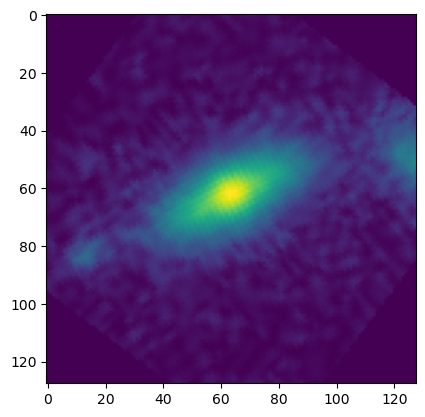

In [41]:
device = 'cuda'
torch.set_printoptions(sci_mode=False)
model = pd.read_pickle('/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/artifacts/0ddf5239-9466-41c5-8aa7-7f222cf815e5')
DS = GalaxyJungle('../data/test/test_solutions_rev1.csv', '../data/test/', transfs)
train_loader = DataLoader(DS, batch_size=1, shuffle=True, num_workers=os.cpu_count())

stuff = next(iter(train_loader))
print('TRUE LABEL\n')
print(stuff[1])
model.eval()
out = model(stuff[0].to(device))
print('PREDICT\n')
print(out)

print('TRUE LABEL - PREDICT\n')
print(stuff[1].to(device) - out)
plt.imshow(stuff[0][0][0])

lossd = pd.read_pickle('/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/artifacts/ec3820ea-6658-47f3-8139-94ad4a8883c5').loss_dict
lossd.keys()
fig, ax = plt.subplots(figsize=(8,8))

ax.grid(alpha=0.3)
ax.plot(range(len(lossd['batch'])), lossd['batch'], label='Training')
ax.plot(range(len(lossd['vbatch'])), lossd['vbatch'], label='Validation')
ax.legend(loc='upper right')
plt.show()